# Constructing the network of respondence

In [85]:
import json
import itertools
import networkx as nx 
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import community
import glob

from itertools import repeat
from helper_func_networks import clean_graph, partition_from_attr, random_color, draw_partition
from datetime import date, datetime

colors = ['#E69F00', '#56B4E9', '#F0E442', '#F1948A', '#7DCEA0']

In [2]:
# read in the scraped data and combine it in one single dictionary
path = "./info_repo_and_issues*.txt"
files = []
for filename in glob.glob(path):
    with open(filename, 'r') as infile:
        files.append(json.load(infile))

dict0 = files[0] # 'vuejs.org' to '012-cn.vuejs.org'
del dict0['vue-requests']
dict1 = files[1] # 'vue-requests' and 'it.vuejs.org'
dict2 = files[2]
dict3 = files[3]
dict4 = files[4]
dict5 = files[5]

dict_all = {}
dict_all.update(dict4) 
dict_all.update(dict5) 
dict_all.update(dict0) 
dict_all.update(dict1) 
dict_all.update(dict2) 
dict_all.update(dict3) 

In [3]:
# save all the data in one file
with open('Issue_tracker_dic.txt', 'w') as outfile:
    json.dump(dict_all, outfile)
outfile.close()

**Structure of the dictionary**

repo     
-- issue     
        -- -- 'title',      
        -- -- 'created_at',      
        -- -- 'created_by_id',     
        -- -- 'created_by_name',      
        -- -- 'gender',      
        -- -- 'closed_at',      
        -- -- 'comments'    
                -- -- -- comment_id     
                -- -- -- -- user     
                -- -- -- -- name     
                -- -- -- -- gender     
                -- -- -- -- created_at
            

In [4]:
# count issues
number_issues = 0

for repo in dict_all.keys(): 
    number_issues += len(dict_all[repo].keys()) 

number_issues

55278

In [5]:
# count comments on issues
number_comments = 0

for repo in dict_all.keys(): 
    for issue in dict_all[repo].keys(): 
        number_comments += len(dict_all[repo][issue]['comments'].keys())#['comments']

number_comments

137645

## Who initiated issues?

In [6]:
# find issue commentors and issue creators
issue_creators = []
issue_commentors = []
for repo in dict_all.keys(): 
    for issue in dict_all[repo].keys():
        issue_creators.append(dict_all[repo][issue]['created_by_id'])
    
        if [comment for comment in list(dict_all[repo][issue]['comments'].keys())] == []: 
            pass
        else: 
            for comment in list(dict_all[repo][issue]['comments'].keys()): 
                issue_commentors.append(dict_all[repo][issue]['comments'][comment]['user'])
                
                
issue_creators = set(issue_creators)
issue_commentors = set(issue_commentors)

In [7]:
# create dictionary that maps names to gender
user_to_gender = {}

for repo in dict_all.keys(): 
    for issue in dict_all[repo].keys():
        user_to_gender[dict_all[repo][issue]['created_by_id']] = dict_all[repo][issue]['gender']
        
        if [comment for comment in list(dict_all[repo][issue]['comments'].keys())] == []: 
            pass
        else: 
            for comment in list(dict_all[repo][issue]['comments'].keys()): 
                user_to_gender[dict_all[repo][issue]['comments'][comment]['user']] = dict_all[repo][issue]['comments'][comment]['gender']

In [8]:
# check whether results are constistent
len(issue_creators.union(issue_commentors)) == len(user_to_gender) 

True

In [9]:
# infer the users genders
creators_to_gender = {}
for creator in issue_creators: 
    creators_to_gender[creator] = user_to_gender[creator]
    
commentors_to_gender = {}
for commentor in issue_commentors: 
    commentors_to_gender[commentor] = user_to_gender[commentor]

In [10]:
# count groups to see how unbalanced the data is
gender_counts_creators = pd.DataFrame(pd.Series(creators_to_gender.values()).value_counts()).T
gender_counts_commentors = pd.DataFrame(pd.Series(commentors_to_gender.values()).value_counts()).T

all_mf = gender_counts_creators["M"] + gender_counts_creators["F"] + gender_counts_commentors["M"] + gender_counts_commentors["F"]
all_mfu = gender_counts_commentors.sum(axis=1) + gender_counts_creators.sum(axis=1)

In [11]:
for frame in [gender_counts_creators, gender_counts_commentors]: 

        count_un = round(float(frame["unkown"]/frame.sum(axis=1)), 2)
        count_m = round(float(frame["M"]/frame.sum(axis=1)), 2)
        count_f = round(float(frame["F"]/frame.sum(axis=1)), 2)
        
        if frame is gender_counts_creators: 
            print('''For issue creators the share is:\n''')   
        else:
            print('''For issue commentors the share is:\n''')
            
        print(f'''M: \t\t{count_m} \nF: \t\t{count_f} \nUnknown: \t{count_un}\n''')

For issue creators the share is:

M: 		0.42 
F: 		0.04 
Unknown: 	0.54

For issue commentors the share is:

M: 		0.45 
F: 		0.05 
Unknown: 	0.5



## Create network of issue creators and commentors

In [12]:
# find bots

name_gender_data = pd.DataFrame.from_dict(user_to_gender, orient='index').reset_index().rename(columns = {"index": "name", 0: "gender"})

counter = 0
genders = []
for name in name_gender_data["name"]: 
    if "bot" in name: 
        counter += 1
    else: 
        genders.append(user_to_gender[name])

In [13]:
all_users = list(user_to_gender.keys()) # all people involved (commentors and creators)
involved_users = [user for user in all_users if "bot" not in user]

In [14]:
#this code does account for people that comment their own issues and calulates also the time bewteen responses

edges_and_weights = []
for repo in list(dict_all.keys()): 
    
    for issue in list(dict_all[repo].keys()):
        
        creator = dict_all[repo][issue]['created_by_id']
        created_at = datetime.strptime(dict_all[repo][issue]['created_at'], '%Y-%m-%dT%H:%M:%S')
        
        if "bot" in creator: # exclude bots
            continue
        
        elif [comment for comment in list(dict_all[repo][issue]['comments'].keys())] == []: # select the issues that have comments 
            pass
        
        else: 
            
            given_comments = [comment for comment in list(dict_all[repo][issue]['comments'].keys())]
            
            if creator == dict_all[repo][issue]['comments'][given_comments[0]]["user"]:
                pass
            
            elif "bot" in dict_all[repo][issue]['comments'][given_comments[0]]["user"]: # exclude bots
                pass 
            
            else: 
                
                commented_at = datetime.strptime(dict_all[repo][issue]['comments'][given_comments[0]]['created_at'], '%Y-%m-%dT%H:%M:%S')
                time_laps = commented_at - created_at
                    
                edges_and_weights.append(tuple([dict_all[repo][issue]['comments'][given_comments[0]]["user"], creator, time_laps]))

            
            for i in range(len(given_comments)-2): 
                
                
                if dict_all[repo][issue]['comments'][given_comments[i+1]]["user"] == dict_all[repo][issue]['comments'][given_comments[i+2]]["user"]: 
                    pass
                
                else: 
                    
                    if "bot" in dict_all[repo][issue]['comments'][given_comments[i+1]]["user"] or "bot" in dict_all[repo][issue]['comments'][given_comments[i+2]]["user"]: # exclude bots
                        pass
                
                    else:
                        com1_created_at = datetime.strptime(dict_all[repo][issue]['comments'][given_comments[i+1]]['created_at'], '%Y-%m-%dT%H:%M:%S')
                        com2_created_at = datetime.strptime(dict_all[repo][issue]['comments'][given_comments[i+2]]['created_at'], '%Y-%m-%dT%H:%M:%S')
                        time_laps = com2_created_at - com1_created_at

                        edges_and_weights.append(tuple([dict_all[repo][issue]['comments'][given_comments[i+2]]["user"], dict_all[repo][issue]['comments'][given_comments[i+1]]["user"], time_laps]))                  

The data is structured in the following way: (node1, node2, weight). An edge of weight "weight" points from node1 to node2. 
Hence, in this network edges are pointing from the first commenter to an issue creator, or from the commentor who answered a question to the one who asked. 

In [15]:
# calculation of the time lags and edge weights
# rescaling of the edge weights

edges_and_weights_resc = []
all_edges_weights = []
for edge in edges_and_weights: 
    days_in_seconds = edge[2].days * 24 * 60 * 60 
    seconds = edge[2].seconds
    time_diff = round((days_in_seconds + seconds) / (60 * 60 * 24), 2) # in days, rounded 
    weight = 180 - time_diff
        
    all_edges_weights.append(tuple([edge[0], edge[1], time_diff]))
    
    if time_diff < (6*30): 
        edges_and_weights_resc.append(tuple([edge[0], edge[1], weight]))
        
        
weight_distr = []
for edge in edges_and_weights_resc: 
    weight_distr.append(-(edge[2] - 180))
    
total_weight_distr = []
for edge in all_edges_weights: 
    total_weight_distr.append((edge[2]))

## Creation of the network

In [16]:
# find unique pairs of people who collaborated with each other 
unique_edges = []
for edge_weights in edges_and_weights_resc: 
    unique_edges.append(edge_weights[:2])

unique_edges = set(unique_edges)

In [17]:
# calclate the edge weights for pairs of people that collaborated more often than once (calculate the average)

final_edge_to_weight = []
for edge in unique_edges:
    cum_weight = 0
    same_edges = []
    for edge_and_weight in edges_and_weights_resc: 
        if edge == edge_and_weight[:2]: 
            cum_weight += edge_and_weight[2]
            same_edges.append(edge_and_weight)
            
        else:
            continue
        
        mean_weight = cum_weight / len(same_edges)
        final_edge_to_weight.append((edge_and_weight[0], edge_and_weight[1], mean_weight))

In [18]:
# Creation of the graph 

issue_g = nx.DiGraph()
issue_g.name = "Creating_and_responding_to_issues"

for user in involved_users:
    issue_g.add_node(user, 
                     gender =  user_to_gender[user])
                      
issue_g.add_weighted_edges_from(final_edge_to_weight)

In [19]:
# creation of the user name to gender dictionary 

username_to_gender_dic = {}
for user in issue_g.nodes(): 
    username_to_gender_dic[user] = issue_g.nodes[user]["gender"]

In [20]:
# store data in a .txt file

with open('username_to_gender_dic.txt', 'w') as outfile:
    json.dump(username_to_gender_dic, outfile)
outfile.close()

In [77]:
# get information about the created graph
# code partially adapted from the lecture

num_nodes = len(issue_g.nodes)
num_edges = len(issue_g.edges)
recip_score = nx.reciprocity(issue_g)
recip_edges = recip_score*num_edges
tot_possible_edges = num_nodes * (num_nodes -1) 
                                                
unrecip_edges = num_edges - recip_edges


print(nx.info(issue_g))
print("Density of the graph: {:.3f} ".format(nx.density(issue_g)))
print("Max possible edges: ", tot_possible_edges)
print("Actual number of edges: ", num_edges)
print("Number of reciprocated edges: ", recip_edges)
print("Number of unreciprocated edges: ", unrecip_edges)
print("Percent of connected dyads that are unreciprocated: {:.1%} ".format(unrecip_edges/num_edges))

Name: Creating_and_responding_to_issues
Type: DiGraph
Number of nodes: 32102
Number of edges: 58231
Average in degree:   1.8139
Average out degree:   1.8139
Density of the graph: 0.000 
Max possible edges:  1030506302
Actual number of edges:  58231
Number of reciprocated edges:  19682.0
Number of unreciprocated edges:  38549.0
Percent of connected dyads that are unreciprocated: 66.2% 


In [23]:
# store network to visualise it using gephi
nx.write_gexf(issue_g, "Creating_and_responding_to_issues_(gender).gexf")

## Investigation of the network of respondence

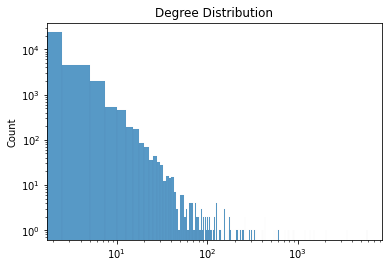

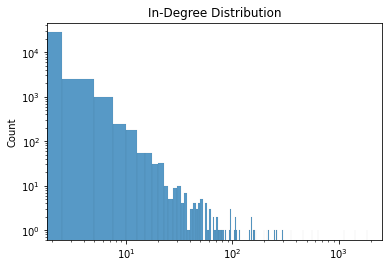

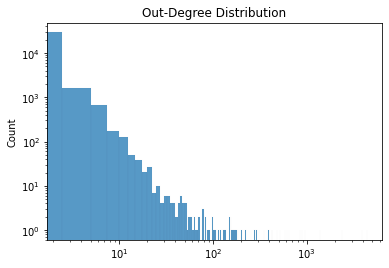

In [81]:
deg_seq = [x[1] for x in issue_g.degree()]
ax = sns.histplot(x=deg_seq, binwidth = 2.5)
ax.set(xscale="log", yscale="log")
#plt.xlim(-0.5, 100)
#plt.ylim(0.1, 10**5)
plt.title("Degree Distribution")
plt.show()

deg_seq = [x[1] for x in issue_g.in_degree()]
ax = sns.histplot(x=deg_seq, binwidth = 2.5)
ax.set(xscale="log", yscale="log")
#plt.xlim(-0.5, 100)
#plt.ylim(0.1, 10**5)
plt.title("In-Degree Distribution")
plt.show()

deg_seq = [x[1] for x in issue_g.out_degree()]
ax = sns.histplot(x=deg_seq, binwidth = 2.5)
ax.set(xscale="log", yscale="log")
#plt.xlim(-0.5, 100)
#plt.ylim(0.1, 10**5)
plt.title("Out-Degree Distribution")
plt.show()

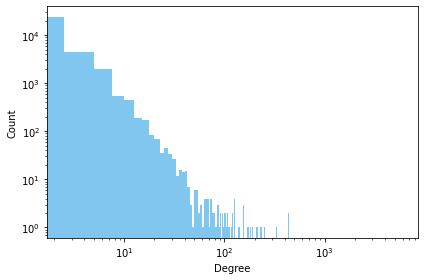

In [82]:
# save distribution in file
deg_seq = [x[1] for x in issue_g.degree()]
ax = sns.histplot(x=deg_seq, binwidth = 2.5, color = colors[1], edgecolor="w")
ax.set(xscale="log", yscale="log")
#plt.xlim(1, 300)
#plt.ylim(0, 10**5)
plt.xlabel("Degree")
#plt.show()

plt.tight_layout()

plt.savefig("PowerLawissue_network.pdf", 
            dpi=350, facecolor='w', edgecolor='w', format="pdf",
            transparent=True, bbox_inches=None, pad_inches=0.1)

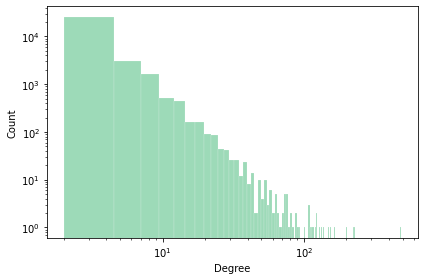

In [86]:
# generate Barabasi-Albert graph and save distribution in file

g_pl1 = nx.barabasi_albert_graph(32102,2)
g_pl1.name="Power-law graph"
#reportOnClustering(g)

deg_seq = [x[1] for x in g_pl1.degree()]
ax = sns.histplot(x=deg_seq, binwidth = 2.5, color = colors[4], edgecolor='w')
ax.set(xscale="log", yscale="log")
#plt.xlim(1, 300)
#plt.ylim(0, 10**5)
plt.xlabel("Degree")
#plt.title("Degree distribution ")

plt.tight_layout()

plt.savefig("PowerLawbarabasi_albert_graph.pdf", 
            dpi=350, facecolor='w', edgecolor='w', format="pdf",
            transparent=True, bbox_inches=None, pad_inches=0.1)

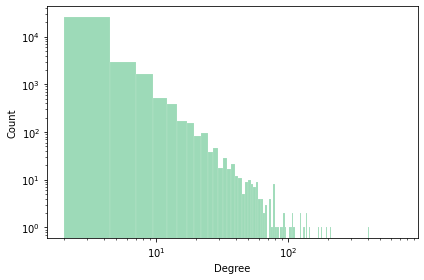

In [87]:
# generation of a power-law graph and save distribution in file

g_pl2 = nx.generators.random_graphs.powerlaw_cluster_graph(32102,2, 0.5)
g_pl2.name="Power-law graph"
#reportOnClustering(g)

deg_seq = [x[1] for x in g_pl2.degree()]
ax = sns.histplot(x=deg_seq, binwidth = 2.5, color = colors[4], edgecolor='w')
ax.set(xscale="log", yscale="log")
#plt.xlim(1, 300)
#plt.ylim(0, 10**5)
plt.xlabel("Degree")
#plt.title("Degree distribution ")

plt.tight_layout()

plt.savefig("PowerLawRandom_graph.pdf", 
            dpi=350, facecolor='w', edgecolor='w', format="pdf",
            transparent=True, bbox_inches=None, pad_inches=0.1)

## Who is better connected?

In [29]:
# code is adapted from the lecture
# find out who is better connected based on category

def who_is_better_connected(network):
    networkdf = pd.DataFrame.from_dict(dict(network.nodes),orient="index")
    
    networkdf["degree"] = pd.Series(dict(nx.degree(network)))
    networkdf["in_degree"] = pd.Series(dict(network.in_degree()))
    networkdf["out_degree"] = pd.Series(dict(network.out_degree()))
    
    networkdf["degree_weighted"] = pd.Series(dict(nx.degree(network, weight='weight')))
    networkdf["in_degree_weighted"] = pd.Series(dict(network.in_degree(weight='weight')))
    networkdf["out_degree_weighted"] = pd.Series(dict(network.out_degree(weight='weight')))
    #print(networkdf.head())
 
    networkdf_m = networkdf[networkdf['gender'] == "M"]
    networkdf_f = networkdf[networkdf['gender'] == "F"]
    networkdf_u = networkdf[networkdf['gender'] == "unkown"]
    
    avg_deg_m = round(sum(networkdf_m["degree"])/len(networkdf_m["degree"]), 1)
    avg_deg_f = round(sum(networkdf_f["degree"])/len(networkdf_f["degree"]), 1)
    avg_deg_u = round(sum(networkdf_u["degree"])/len(networkdf_u["degree"]), 1)
    
    avg_in_deg_m = round(sum(networkdf_m["in_degree"])/len(networkdf_m["in_degree"]), 1)
    avg_in_deg_f = round(sum(networkdf_f["in_degree"])/len(networkdf_f["in_degree"]), 1)
    avg_in_deg_u = round(sum(networkdf_u["in_degree"])/len(networkdf_u["in_degree"]), 1)
    
    avg_out_deg_m = round(sum(networkdf_m["out_degree"])/len(networkdf_m["out_degree"]), 1)
    avg_out_deg_f = round(sum(networkdf_f["out_degree"])/len(networkdf_f["out_degree"]), 1)
    avg_out_deg_u = round(sum(networkdf_u["out_degree"])/len(networkdf_u["out_degree"]), 1)
    
    
    avg_deg_m_weighted = round(sum(networkdf_m["degree_weighted"])/len(networkdf_m["degree_weighted"]), 1)
    avg_deg_f_weighted = round(sum(networkdf_f["degree_weighted"])/len(networkdf_f["degree_weighted"]), 1)
    avg_deg_u_weighted = round(sum(networkdf_u["degree_weighted"])/len(networkdf_u["degree_weighted"]), 1)
    
    avg_in_deg_m_weighted = round(sum(networkdf_m["in_degree_weighted"])/len(networkdf_m["in_degree_weighted"]), 1)
    avg_in_deg_f_weighted = round(sum(networkdf_f["in_degree_weighted"])/len(networkdf_f["in_degree_weighted"]), 1)
    avg_in_deg_u_weighted = round(sum(networkdf_u["in_degree_weighted"])/len(networkdf_u["in_degree_weighted"]), 1)
    
    avg_out_deg_m_weighted = round(sum(networkdf_m["out_degree_weighted"])/len(networkdf_m["out_degree_weighted"]), 1)
    avg_out_deg_f_weighted = round(sum(networkdf_f["out_degree_weighted"])/len(networkdf_f["out_degree_weighted"]), 1)
    avg_out_deg_u_weighted = round(sum(networkdf_u["out_degree_weighted"])/len(networkdf_u["out_degree_weighted"]), 1)
    
    
    
    print(f'''
          The average dregree for male is {avg_deg_m}.
          The average dregree for female high is {avg_deg_f}. 
          The average dregree for unknown is {avg_deg_u}.
          
          The average in_degree for male is {avg_in_deg_m}.
          The average in_degree for female high is {avg_in_deg_f}. 
          The average in_degree for unknown is {avg_in_deg_u}.
          
          The average out_degree for male is {avg_out_deg_m}.
          The average out_degree for female high is {avg_out_deg_f}. 
          The average out_degree for unknown is {avg_out_deg_u}.
          
          
          
          The average dregree weighted for male is {avg_deg_m_weighted}.
          The average dregree weighted for female is {avg_deg_f_weighted}. 
          The average dregree weighted for unknown is {avg_deg_u_weighted}.
          
          The average in_degree weighted for male is {avg_in_deg_m_weighted}.
          The average in_degree weighted for female is {avg_in_deg_f_weighted}. 
          The average in_degree weighted for unknown is {avg_in_deg_u_weighted}.
          
          The average out_degree weighted for male is {avg_out_deg_m_weighted}.
          The average out_degree weighted for female is {avg_out_deg_f_weighted}. 
          The average out_degree weighted for unknown is {avg_out_deg_u_weighted}.
          
          ''')
        
who_is_better_connected(issue_g)


          The average dregree for male is 4.4.
          The average dregree for female high is 3.5. 
          The average dregree for unknown is 3.0.
          
          The average in_degree for male is 2.1.
          The average in_degree for female high is 1.7. 
          The average in_degree for unknown is 1.6.
          
          The average out_degree for male is 2.3.
          The average out_degree for female high is 1.8. 
          The average out_degree for unknown is 1.4.
          
          
          
          The average dregree weighted for male is 745.4.
          The average dregree weighted for female is 592.7. 
          The average dregree weighted for unknown is 499.8.
          
          The average in_degree weighted for male is 354.6.
          The average in_degree weighted for female is 294.5. 
          The average in_degree weighted for unknown is 264.8.
          
          The average out_degree weighted for male is 390.8.
          The average ou

Interpretation: If the in_degree is higher: this type of user got more people answering their questions.

If the out_degree is higher: this type of user commented on more different people's questions. 

### EI Index

In [36]:
# code adapted from the lecture 

issue_g_gender = issue_g.copy()
nodes_to_remove = []
for node in issue_g_gender.nodes(): 
    if issue_g_gender.nodes[node]["gender"] == "unkown": 
        nodes_to_remove.append(node)
    else: 
        pass
        
issue_g_gender.remove_nodes_from(nodes_to_remove)      


for i in ["gender"]:
    if len(issue_g_gender.edges) == 0:
        print("cannot calculate EI-index on a graph with no edges")

    else: 
        E = len([x for x in issue_g_gender.edges if issue_g_gender.nodes[x[0]][i] != issue_g_gender.nodes[x[1]][i]])
        I = len([x for x in issue_g_gender.edges if issue_g_gender.nodes[x[0]][i] == issue_g_gender.nodes[x[1]][i]])
        
        ei_index =  (E - I) / len(issue_g_gender.edges)

    print("EI Index for attribute \"%s\":\t %1.3f " % (i,ei_index))

EI Index for attribute "gender":	 -0.717 


### Assortativity

In [37]:
# code adapted from the lecture

#network = issue_g_gender.copy()
network = issue_g.copy()

attribute = "gender"

attribute_map = {
    #"M":"male",
    "F":"female", 
    "unkown":"unknown"
}

assort_coeff_1 = nx.attribute_assortativity_coefficient(network,attribute)
print("Assortativity by {}: (unfiltered) {:.3f}".format(attribute,assort_coeff_1))

nodelist = [node_name for node_name in network.nodes if network.nodes[node_name][attribute] in attribute_map.keys()]
print("The filtered list contains {} of {} total nodes".format(len(nodelist),len(network.nodes)))

assort_coeff_2 = nx.attribute_assortativity_coefficient(network,attribute,nodelist)
print("Assortativity by {}: (filtered) {:.3f}".format(attribute,assort_coeff_2))

Assortativity by gender: (unfiltered) 0.059
The filtered list contains 18338 of 32102 total nodes
Assortativity by gender: (filtered) 0.012


In [39]:
nx.degree_assortativity_coefficient(issue_g)

-0.1919302869061351

### Reciprocity

In [42]:
# Reciprocity for ties
all_recip =  nx.algorithms.reciprocity(issue_g, issue_g.nodes) # returns reciprocity value per node

<AxesSubplot:ylabel='Count'>

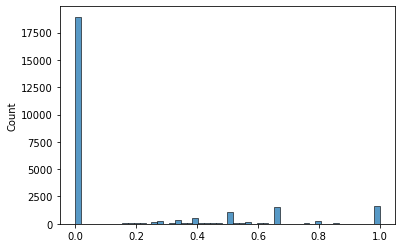

In [43]:
sns.histplot(pd.Series(all_recip))

### Degree based centrality measures

<AxesSubplot:ylabel='Count'>

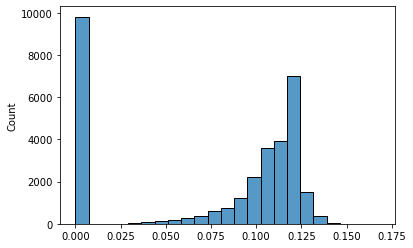

In [44]:
cc = nx.closeness_centrality(issue_g)
sns.histplot(pd.Series(cc)) # 0: nodes that are isolates 

In [45]:
#bc = nx.betweenness_centrality(issue_g)
#sns.histplot(pd.Series(bc))
#ax.set(xscale="log", yscale="log")# because the distribution is extreamly skewed 
#plt.show()

In [46]:
#dg = nx.degree_centrality(issue_g)
#ax = sns.histplot(pd.Series(dg))
#ax.set(xscale="log", yscale="log") # because the distribution is extreamly skewed 
#plt.show()

# Reaction time and gender

In [47]:
# filter data 
male_creators = {k: v for k, v in creators_to_gender.items() if v == "M"}
female_creators = {k: v for k, v in creators_to_gender.items() if v == "F"}
unknown_creators = {k: v for k, v in creators_to_gender.items() if v == "Unknown"}

In [49]:
# calctulation of the time it took users to react to a post (by gender)
reaction_time_male_init = []
reaction_time_female_init = []
reaction_time_unk_init = []

for interaction in edges_and_weights: 
    initiator = interaction[1]
    respondend = interaction[0]
    time_diff = interaction[2]
    days_in_secs = time_diff.days * 24 * 60 * 60 
    secs = time_diff.seconds
    
    laps = round(((secs + days_in_secs) / (60 * 60)) *2) / 2 # this is hours
    
    if 0 < laps < (24 *7): ## this is one day (minutes) 
    
        if user_to_gender[initiator] == "M": 
            reaction_time_male_init.append(laps)
        elif user_to_gender[initiator] == "F": 
            reaction_time_female_init.append(laps)
        else: 
            reaction_time_unk_init.append(laps)  

In [52]:
reaction_data_f = pd.DataFrame(pd.Series(reaction_time_female_init).value_counts()).reset_index().rename(columns = {"index" : "time", 0 : "value_counts"})
reaction_data_m = pd.DataFrame(pd.Series(reaction_time_male_init).value_counts()).reset_index().rename(columns = {"index" : "time", 0 : "value_counts"})
reaction_data_u = pd.DataFrame(pd.Series(reaction_time_unk_init).value_counts()).reset_index().rename(columns = {"index" : "time", 0 : "value_counts"})

In [55]:
# calculate the share of obeerservations
for data in [reaction_data_f, reaction_data_m, reaction_data_u]:
    data["share"] = data["value_counts"].map(lambda x: x / sum(data["value_counts"]))
    data = data.sort_values(by = ["time"]).reset_index().drop(columns = ["index"]).copy()

In [56]:
reaction_data_f.head()

,time,value_counts,share
0,0.5,467,0.188839
1,1.0,223,0.090174
2,1.5,154,0.062273
3,2.0,103,0.041650
4,3.0,78,0.031541


In [57]:
# generate the normalised data frame

norm_f = []
norm_m = []
norm_u = []

for i in range(len(reaction_data_f)):
    share = reaction_data_f.iloc[i]["share"]
    time = str(reaction_data_f.iloc[i]["time"])
    how_often = int(round(len(reaction_time_male_init)*share))
    norm_f.extend(repeat(time, how_often))
    
for i in range(len(reaction_data_u)):
    share = reaction_data_u.iloc[i]["share"]
    time = str(reaction_data_u.iloc[i]["time"])
    how_often = int(round(len(reaction_time_male_init)*share))
    norm_u.extend(repeat(time, how_often))
    
for i in range(len(reaction_data_m)):
    share = reaction_data_m.iloc[i]["share"]
    time = str(reaction_data_m.iloc[i]["time"])
    how_often = int(round(len(reaction_time_male_init)*share))
    norm_m.extend(repeat(time, how_often))

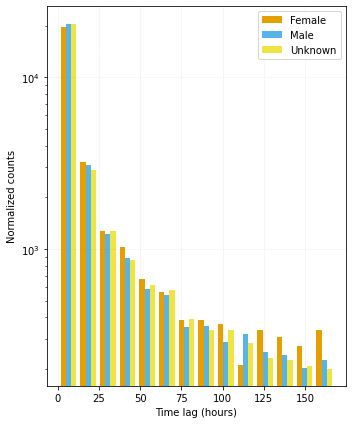

In [93]:
# Plot the normalised data

colors = ['#E69F00', '#56B4E9', '#F0E442']
names = ['Female', 'Male', 'Unknown']

norm_f = [float(x) for x in norm_f]
norm_m = [float(x) for x in norm_m]
norm_u = [float(x) for x in norm_u]


plt.figure(figsize = (5, 6))
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha = 0.2)
plt.hist([norm_f, norm_m, norm_u], color = colors, label=names, bins = 14)


# Plot formatting
plt.legend()
plt.xlabel('Time lag (hours)')
plt.ylabel('Normalized counts')
plt.yscale('log') 
#plt.xscale('log') 
plt.tight_layout()
#plt.title("Reponse time in minutes\n differentiated by the initiator's gender")

plt.savefig("Response_time_gender.pdf", dpi=350, facecolor='w', edgecolor='w', format="pdf",
        transparent=True, bbox_inches=None, pad_inches=0.1)

In [91]:
# create and save data frame from the regression

time_diff_data = []
accord_gender = []

for interaction in edges_and_weights: 
    initiator = interaction[1]
    respondend = interaction[0]
    time_diff = interaction[2]
    days_in_secs = time_diff.days * 24 * 60 * 60 
    secs = time_diff.seconds
    
    laps = round(((secs + days_in_secs) / (60)) *2) / 2 # this is minutes
    
    if 0 < laps < (7*24* 60): # a week in minutes
    
        time_diff_data.append(laps)
        accord_gender.append(user_to_gender[initiator])

regression_data = pd.DataFrame(list(zip(time_diff_data, accord_gender)), columns =['Time_laps', 'Gender'])
regression_data.head(5)

,Time_laps,Gender
0,232.0,unkown
1,630.0,unkown
2,53.0,unkown
3,299.5,M
4,134.0,M


In [92]:
regression_data.to_csv('regression_data.csv', index = False) 

## Modularity of the network

Name: 
Type: Graph
Number of nodes: 25973
Number of edges: 48390
Average degree:   3.7262
The modularity by gender is: 0.030


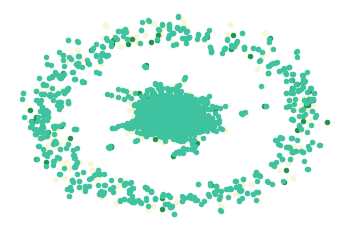

The modularity by Louvain (best) is: 0.603


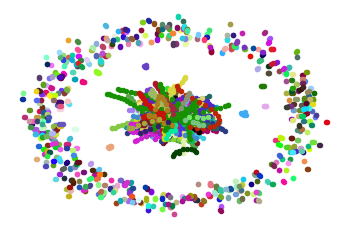

In [75]:
# code is adapted from the lecture

attr_list = ["gender"]

triads_g_nondi_clean = clean_graph(issue_g,attribute_list=attr_list)

print(nx.info(triads_g_nondi_clean))

pos = nx.spring_layout(triads_g_nondi_clean) # let's have one single position value for all of the graphs we are comparing.

for i in attr_list:
    partition = partition_from_attr(triads_g_nondi_clean,i)
    print("The modularity by {} is: {:.3f}".format(i, community.modularity(partition,triads_g_nondi_clean)))
    draw_partition(triads_g_nondi_clean,partition_from_attr(triads_g_nondi_clean,i),pos)

# Use the Louvain method for community detection
partition = community.best_partition(triads_g_nondi_clean)
print("The modularity by Louvain (best) is: {:.3f}".format( community.modularity(partition,triads_g_nondi_clean)))
draw_partition(triads_g_nondi_clean,partition,pos)